#### __***Loading the modules***__

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, Reshape, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

np.random.seed(5)
tf.get_logger().setLevel(40) # suppress deprecation messages

Kaggle Data Source Link - [Kaggle | Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv)

The Pima Indian Diabetes dataset is used to predict whether or not the diagnosed patient has diabetes, which is also a Binary Classification problem, based on the various diagnostic feature values provided. The dataset used for this analysis is obtained from Kaggle. Although the dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The patient dynamics provided in this dataset is that of female patients who are at least 21 years old and of Pima Indian heritage.  The datasets used might be derived and transformed datasets from original datasets. The sources of the original datasets will be mentioned and I would strongly recommend to look at the original data for more details on the data description and for a more detailed analysis.

#### __***Loading data***__

In [6]:
data = pd.read_csv('data/diabetes.csv')
print("Shape:", data.shape)
data.head()

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data Distribution


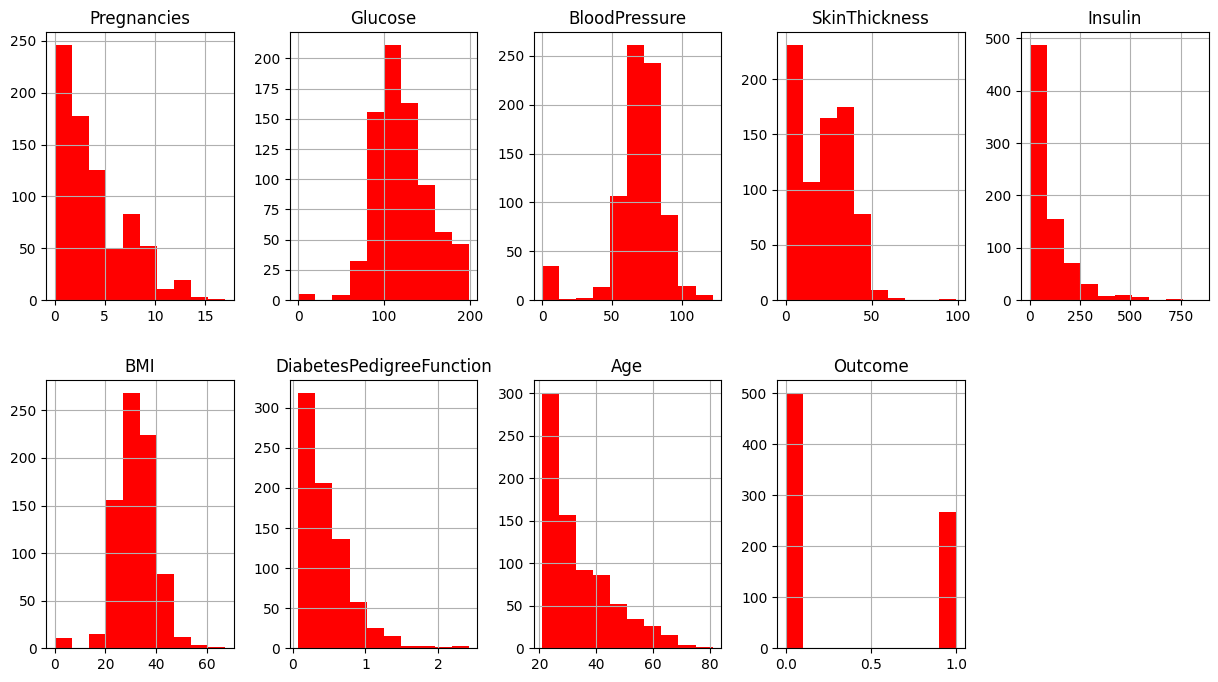

In [14]:
print('Data Distribution')
data.hist(layout = (2,5), figsize=(15,8), color = 'r')
plt.show()

#### __***This looks like a fairly imbalanced dataset***__

In [ ]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

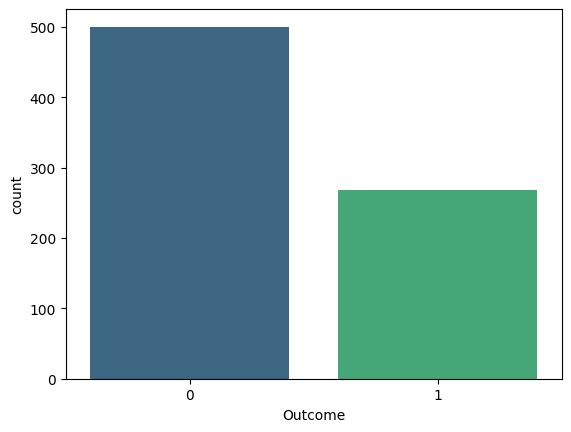

In [18]:
sns.countplot(x="Outcome", data=data, palette="viridis")
plt.show()

#### __***Null Values***__

In [19]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### __***Duplicates***__

In [ ]:
data.duplicated().any()

False

#### __***Summary Statistics***__

In [20]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


##### __There are two main observations from this data description :__

###### __1. There are few records for which BMI, Glucose, Blood Pressure are 0. It might be possible that these values where not recorded properly during the data capture process. So, it is better not to consider these rows for the training purpose.__
###### __2. There are some outliers observed from the max values in no. of Pregnancies, Skin Thickness, Insulin etc, which needs further inspection.__

#### __***Data Correlation***__

In [21]:
data.corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

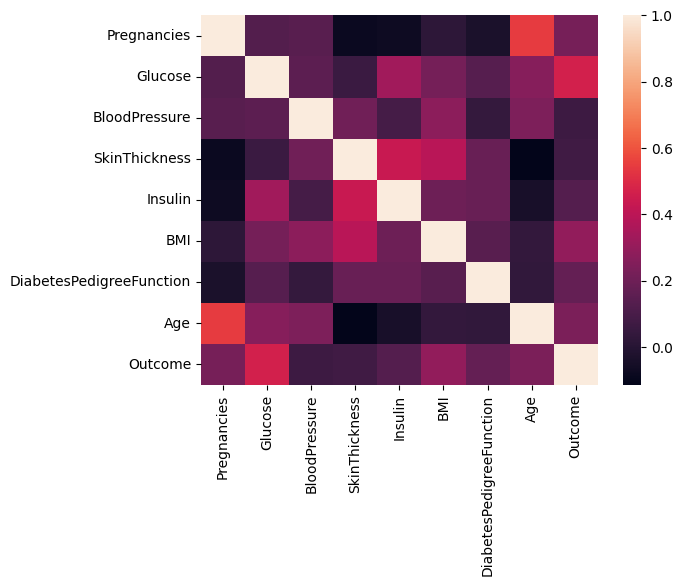

In [22]:
sns.heatmap(data.corr())
plt.show()

##### __***It is observed that the features does not have a strong correlation (>0.5) with the target variable.***__

#### __***Outlier Check***__

In [23]:
data[(data['BMI'] == 0) & (data['Glucose'] == 0) & (data['BloodPressure'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [24]:
data[(data['Glucose'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


##### __From the above observation, it looks like the data does have alot of noise, as there are multiple cases where some of the key features are 0. But, following human intuition, since blood glucose level is one of the key features to observe diabetes, I would consider dropping all records where Glucose value is 0.__

#### __***Noise removal***__

In [26]:
cleaned_data = data[(data['Glucose'] != 0)]
cleaned_data.shape

(763, 9)

#### __***Feature Engineering***__

In [28]:
feature_engg_data = cleaned_data.copy()
outlier_data = cleaned_data.copy()
factor = 3 # Using a factor of 3, following Nelson's rule 1 to remove outliers
# Only for non-categorical fields
columns_to_include = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

for column in columns_to_include:
    upper_lim = feature_engg_data[column].mean () + feature_engg_data[column].std () * factor
    lower_lim = feature_engg_data[column].mean () - feature_engg_data[column].std () * factor
    feature_engg_data = feature_engg_data[(feature_engg_data[column] < upper_lim) & (feature_engg_data[column] > lower_lim)]

outlier_data = pd.concat([outlier_data, feature_engg_data]).drop_duplicates(keep=False)

print(feature_engg_data.shape)
print(outlier_data.shape)

(688, 9)
(75, 9)


##### __In the following section in-order to build the model, we will need to normalize the data and split the data into train, validation and test dataset. The outlier data that we have, we will keep it separate, just in case to see how does our model performs on the outlier dataset.__

#### __***Normalization***__

In [29]:
def normalize_data(df):
    val = df.values
    min_max_normalizer = preprocessing.MinMaxScaler()
    norm_val = min_max_normalizer.fit_transform(val)
    df2 = pd.DataFrame(norm_val, columns=df.columns)
    return df2

norm_feature_engg_data = normalize_data(feature_engg_data)
norm_outlier_data = normalize_data(outlier_data)

##### __In the previous steps we have done some fundamental steps to understand and prepare the data so that it can be used for further modeling. Let's split the data and then we will try to apply the feature importance and sensitivity analysis methods for influence based explainability.__

#### __***Train-Test split***__

In [30]:
input_data = norm_feature_engg_data.drop(['Outcome'],axis='columns')
targets =norm_feature_engg_data.filter(['Outcome'],axis='columns')

x, x_test, y, y_test = train_test_split(input_data,targets,test_size=0.1,train_size=0.9, random_state=5)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.22,train_size =0.78, random_state=5)

#### __***Feature Importance***__

##### __Feature importance is a technique that allocates a particular score to the input features present in the dataset based on the usefulness of the features in predicting the target value. We will apply the random forest based feature importance method using the Scikit-Learn Python framework. This is a model specific global explanability method. But it is quite human-friendly explanation method for structured data. It is quite consistent with how human beings try to inspect or interpret natural phenomena in life.__

In [31]:
def apply_RFC(X,y,columns):
    rfc = RFC(n_estimators=500, min_samples_leaf=round(len(X)*.01), random_state=5, n_jobs=-1)
    imp_features = rfc.fit(X,y).feature_importances_
    imp_features = pd.DataFrame(imp_features, columns=['Feature Importance'], index=columns)
    imp_features.sort_values(by=['Feature Importance'], inplace=True, ascending=False)
    imp_features['Moving Sum'] = imp_features['Feature Importance'].cumsum()
    imp_features = imp_features[imp_features['Moving Sum']<=0.95]
    top_features = imp_features.index.tolist()
    return imp_features, top_features

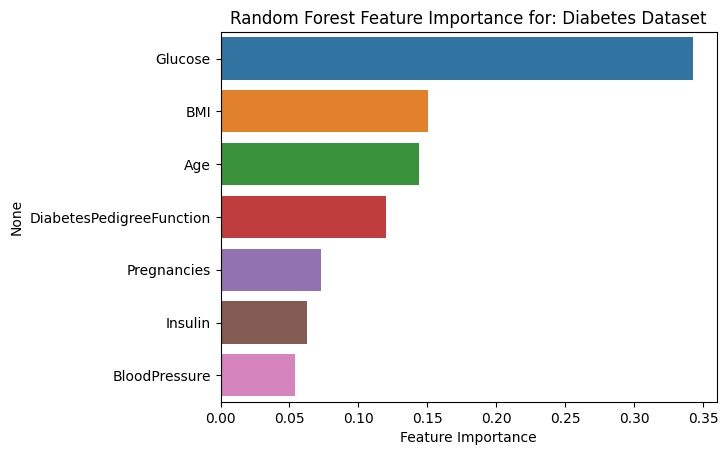

In [33]:
important_features, top_features = apply_RFC(x,y, data.columns.drop('Outcome'))
sns.barplot(x=important_features['Feature Importance'], y=important_features.index, palette = 'tab10')
plt.title('Random Forest Feature Importance for: '+"Diabetes Dataset")
plt.show()

##### __From the above plot we can observe that Glucose or amount of blood glucose level is the most influential feature for determining the presence of diabetes. BMI and Age can also play a vital role in determining the presence of diabetes. This observation is quite consistent with our prior knowledge for Diabetes Detection. This is very useful for model interpretebility, as logicaly speaking also, Blood Glubose play maximum importance for Diabetes detection.__

#### __***Sensitivity Analysis***__

##### __Sensitivity analysis is a quantitative process that approximates uncertainty in forecasts by altering the assumptions made about important input features used by the forecasting model. In sensitivity analysis, the individual input feature variables are increased or decreased to assess the impact of the individual features on the target outcome. Although, I have observed experts applying Sensitivity Analysis to train and re-train a model. But we will apply sensitivity analysis on a trained model to observe the sensitivity of the features towards the target outcome and how it can be used as a model agnostic local explainability method to explain black-box models. We will apply the 6-σ (six sigma) variation rule for Sensitivity analysis for the classification problem of Diabetes Detection.__

In [34]:
def model():
    inp = Input(shape=(x_train.shape[1],))
    x = Dense(40, activation='relu')(inp)
    x = Dense(40, activation='relu')(x)
    op = Dense(2, activation='softmax')(x)
    model = Model(inputs=inp, outputs=op)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = model()
model.fit(x_train, to_categorical(y_train), batch_size=64, epochs=300, verbose=1)

In [ ]:
model.evaluate(x_test, to_categorical(y_test))[1]

3/3 [==============================] - 0s 2ms/step - loss: 0.5551 - accuracy: 0.8406


0.8405796885490417

##### __Although we are not concerned about the final model accuracy, but we do have a decent model to try sensitivity analysis on. Next, we will take a query instance to perform the 6-σ (six sigma) variation rule for Sensitivity analysis on the query instance.__

##### __Let's take a look at the normalized query data instance in which all the features are in the range of (0.0 - 1.0)__

In [37]:
query_instance = x_test.iloc[5].values.reshape((1,) + x_test.iloc[5].shape)
df_query = pd.DataFrame(query_instance, columns = input_data.columns)
df_query

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.538462,0.883871,0.612245,0.35,0.462651,0.505714,0.384266,0.5


In [38]:
predicted_outcome = np.argmax(model.predict(query_instance))
true_label = int(y_test.iloc[5][0])
print(f" The true label is : {true_label}")
print(f" The predicted outcome is : {predicted_outcome}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
 The true label is : 1
 The predicted outcome is : 1


##### __We can clearly see the model is correctly predicting the presence of diabetes. Now, let's see if it changes when we are doing sensitivity analysis, one by one for all the features.__

##### __The measure for standard deviation(σ) can be calculated on the nomalized training data as we will be using the normalized data for the prediction part.__

In [41]:
sigma_glucose = np.std(x['Glucose'])
sigma_bmi = np.std(x['BMI'])
sigma_age = np.std(x['Age'])
sigma_dpf = np.std(x['DiabetesPedigreeFunction'])
sigma_pregnancies = np.std(x['Pregnancies'])
sigma_insulin = np.std(x['Insulin'])
sigma_bp = np.std(x['BloodPressure'])

#### __***Sensitivity Analysis plot using the 6-σ variation method***__

In [44]:
def sensitivity_analysis_plot(measure_tuple):
    (measure, sigma) = measure_tuple
    sensitivity_output = []
    original_value = df_query[measure].copy()
    for k in [-3, -2, -1, 1, 2, 3]:
        df_query[measure] = original_value.copy()
        df_query[measure] = np.clip(df_query[measure] + k * sigma, 0.0, 1.0)
        sensitivity_output.append(np.argmax(model.predict(df_query.values, verbose=0)))
    plt.plot(['-3σ', '-2σ', '-σ', 'σ', '2σ', '3σ'], sensitivity_output, 'r.-', label = 'Sensitivity output')
    plt.axhline(y = predicted_outcome, color = 'b', linestyle = '--', label = 'Original Prediction')
    plt.title(f'6-σ variation sensitity plot for the feature: {measure}')
    plt.legend()
    plt.show()

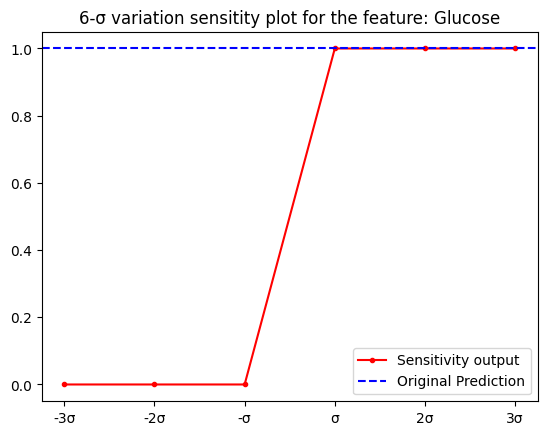

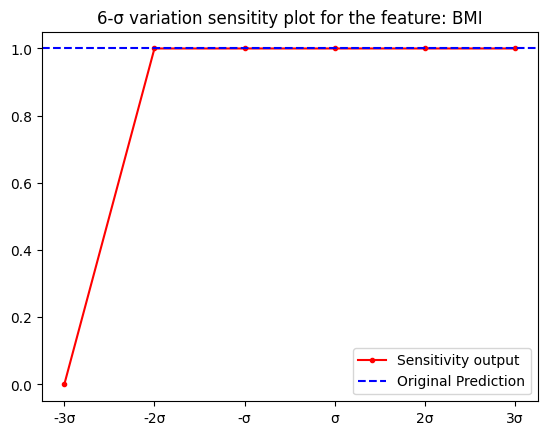

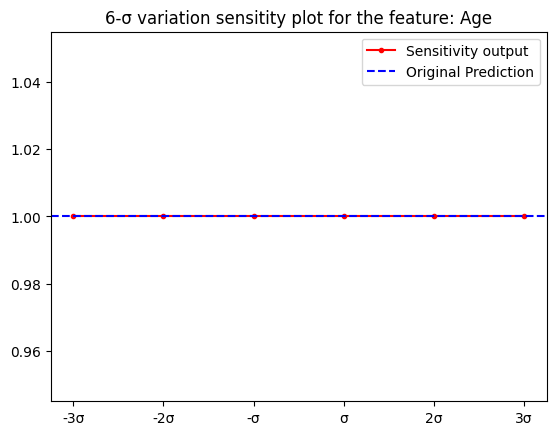

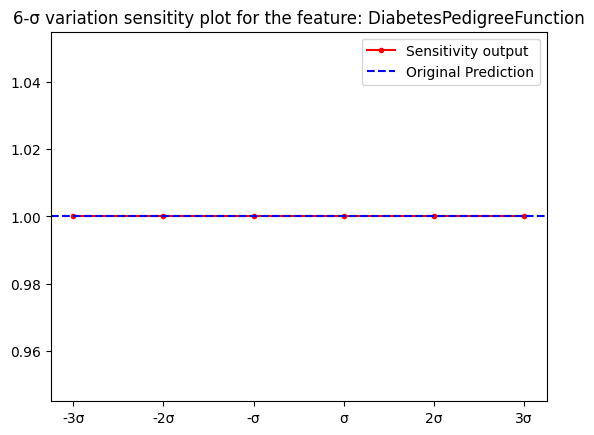

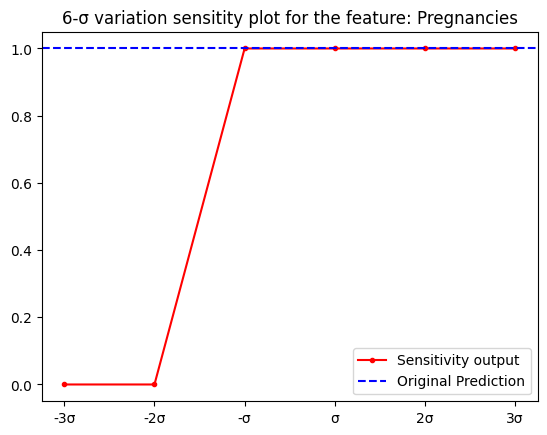

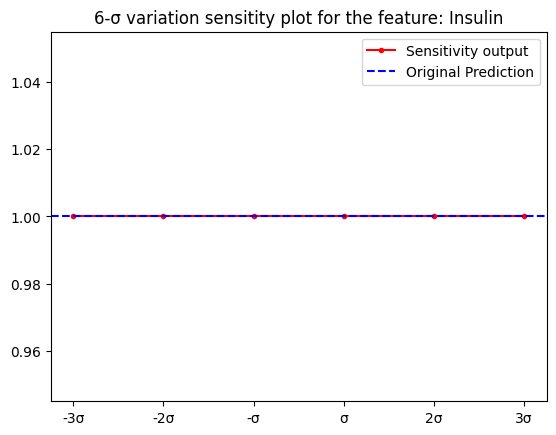

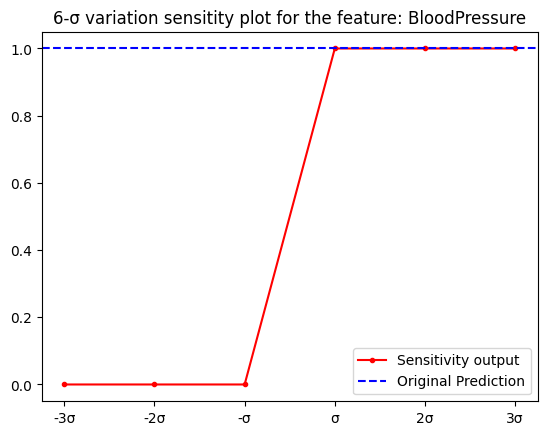

In [47]:
measure_tuple_list = [('Glucose', sigma_glucose),
                     ('BMI', sigma_bmi),
                     ('Age', sigma_age),
                     ('DiabetesPedigreeFunction', sigma_dpf),
                     ('Pregnancies', sigma_pregnancies),
                     ('Insulin', sigma_insulin),
                     ('BloodPressure', sigma_bp)]

for measure_tuple in measure_tuple_list:
    sensitivity_analysis_plot(measure_tuple)

##### __From the above plots, we observe how each of the features are sensitive towards positive or negative changes and how each feature contributes towards influencing the model outcome.The features about Insulin, Diabetes Pedigree Function and Number of Preganancies doesn't seem to be sensitive towards any changes. The features giving information about Glucose, BMI, Blood Pressure seems to positive influence towards the outcome. That means, if the values for these features are increased, it may lead to the presence of diabetes according to the model. SUrprisingly, the feature Age shows a negative influence, which means if the age is increased, the model is less sensitive towards predicting the outcome as diabetes. This is contradicting our prior knowledge and hence is quite an interesting observation and needs to be inspected further.__

#### __***Final Thoughts***__

##### __We have seen how influence based methods like feature importance and sensitivity analysis can be applied to explain the influence of features towards the model's decision making process. But I have only show examples related to classification problem. I would strongly recommend you to try out these methods for explaining models used for regression based problems as well.__

1. Kaggle | Pima Indians Diabetes Database - https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv
2.  How to Calculate Feature Importance With Python | Machine Learning Mastery - https://machinelearningmastery.com/calculate-feature-importance-with-python/
3. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073